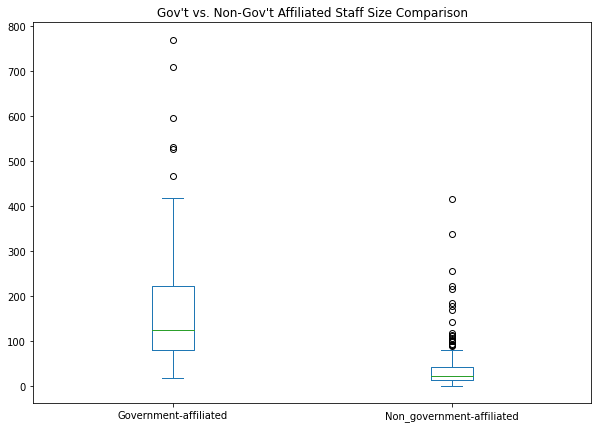

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('database.csv')

total_staff = df['Total_Staff_Size']
gov = df.loc[df['Affiliation'] == 'Government-affiliated']
uni = df.loc[df['Affiliation'] == 'University-affiliated']
cor = df.loc[df['Affiliation'] == 'Corporate (for-profit)']
pol = df.loc[df['Affiliation'] == 'Political Party-affiliated']
un = df.loc[df['Affiliation'] == 'Unaffiliated']
non_gov = df.loc[df['Affiliation'] != 'Government-affiliated']

gov_staff = gov['Total_Staff_Size']
non_gov_staff = non_gov['Total_Staff_Size']

col_names = ['Government-affiliated', 'Non_government-affiliated']

data = pd.concat([gov_staff, non_gov_staff], axis=1)
data.columns = col_names
data.plot.box(figsize=(10,7), title="Gov't vs. Non-Gov't Affiliated Staff Size Comparison")

# plt.show(block=True)
fig = plt.gcf()
fig.savefig('staff.png')

     Government-affiliated  Non_government-affiliated
0                43.536557                        NaN
1                23.854967                        NaN
2                41.339897                        NaN
3                37.107624                        NaN
4                33.880274                        NaN
..                     ...                        ...
653                    NaN                   5.727536
654                    NaN                   0.503289
655                    NaN                        NaN
656                    NaN                        NaN
657                    NaN                        NaN

[658 rows x 2 columns]


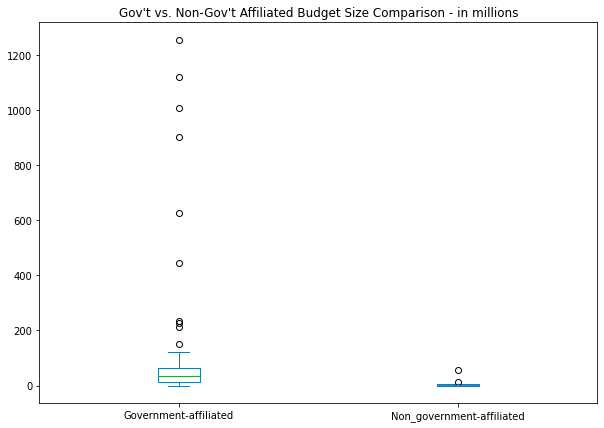

In [19]:
gov_budget = gov['USD_Budget_Size']
non_gov_budget = non_gov['USD_Budget_Size']

col_names = ['Government-affiliated', 'Non_government-affiliated']

data2 = pd.concat([gov_budget, non_gov_budget], axis=1)
data2.columns = col_names
data2 = data2.replace('\$','', regex=True)
data2 = data2.replace(',','', regex=True)
data2 = data2.astype(float)
data2= data2/1000000 
print(data2)

data2.plot.box(figsize=(10,7), title="Gov't vs. Non-Gov't Affiliated Budget Size Comparison - in millions")

fig = plt.gcf()
fig.savefig('budget.png')

In [32]:
import yahoo_fin.stock_info as si
import pandas as pd
import datetime as dt
import numpy as np
import streamlit as st


class PM:
    def __init__(self, tickers, start_date=dt.date(2020, 1, 1), end_date=None):
        self.tickers = [ticker.upper() for ticker in tickers]
        self.start_date = start_date
        self.end_date = end_date
        self.risk_free_rate = 0.0125 #make this choosable
    

    @property
    @st.cache(ttl=86400, persist=False)
    def generate_price_df(self):
        price_df = pd.DataFrame()
        tickers = self.tickers
        for ticker in tickers:
            price = si.get_data(ticker, start_date=self.start_date)
            price_df = pd.concat([price_df, price['adjclose']], axis=1)
        price_df = price_df.set_axis(tickers, axis=1, inplace=False)
        return price_df

    @property
    @st.cache(ttl=86400, persist=False)
    def get_returns(self):
        return np.log(self.generate_price_df / self.generate_price_df.shift(1))

    @property
    @st.cache(ttl=86400, persist=False)
    def get_mean_returns(self):
        return self.get_returns.mean()
    
    @property
    @st.cache(ttl=86400, persist=False)
    def get_covariance(self):
        return self.get_returns.cov()
    
    @property
    @st.cache(ttl=86400, persist=False)
    def get_correlation(self):
        return self.get_returns.corr()

    @property
    @st.cache(ttl=86400, persist=False)
    def generate_random_weights(self):
        weights = np.random.random(len(self.tickers))
        weights /= np.sum(weights)
        return weights

    @property
    @st.cache(ttl=86400, persist=False)
    def calculate_return(self):
        return np.sum(self.generate_random_weights * self.get_mean_return()) * 252
    
    @property
    @st.cache(ttl=86400, persist=False)
    def calculate_volatility(self):
        return np.sqrt(np.dot(self.generate_random_weights.T, np.dot(self.get_covariance, self.generate_random_weights)))

    # @property
    @st.cache(ttl=86400, persist=False)
    def monte_carlo_simulation(self):
        accumulated_return = [] # Returns list
        accumulated_volatility = [] # Volatility list
        accumulated_SR = [] # Sharpe Ratio list
        accumulated_weight = [] # Stock weights list
        highest_SR = []
        top5_SR = []

        predicted_return = self.get_returns
        predicted_return_mean = predicted_return.mean() 
        covariance = predicted_return.cov() * 252
        for i in range(30000):
            # Generate random weights
            weights = np.random.random(len(self.tickers))
            weights /= np.sum(weights)
            
            # Add return using those weights to list
            ret_1 = np.sum(weights * predicted_return_mean) * 252
            accumulated_return.append(ret_1)
            
            # Add volatility or standard deviation to list
            vol_1 = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
            accumulated_volatility.append(vol_1)
            
            # Get Sharpe ratio
            SR_1 = (ret_1 - self.risk_free_rate) / vol_1
            accumulated_SR.append(SR_1)
            
            # Store the weights for each portfolio
            accumulated_weight.append(weights)

        accumulated_return = np.array(accumulated_return)
        accumulated_volatility = np.array(accumulated_volatility)
        accumulated_SR = np.array(accumulated_SR)
        accumulated_weight = np.array(accumulated_weight)
        
        volatility_idx = np.argsort(accumulated_volatility)
        idx = np.argmax(accumulated_SR)

        return accumulated_return.round(4), accumulated_volatility.round(4), accumulated_SR.round(4), accumulated_weight.round(4), volatility_idx, idx
    


endDate,2020-09-26,2019-09-28,2018-09-29,2017-09-30
Breakdown,,,,
investments,5335000000,58093000000,30845000000,-33542000000
changeToLiabilities,-1981000000,-2548000000,9172000000,8373000000
totalCashflowsFromInvestingActivities,-4289000000,45896000000,16066000000,-46446000000
netBorrowings,2499000000,-7819000000,432000000,29014000000
totalCashFromFinancingActivities,-86820000000,-90976000000,-87876000000,-17974000000
changeToOperatingActivities,881000000,-896000000,30016000000,-8480000000
issuanceOfStock,880000000,781000000,669000000,555000000
netIncome,57411000000,55256000000,59531000000,48351000000
changeInCash,-10435000000,24311000000,5624000000,-195000000


In [33]:
import yahoo_fin.stock_info as si

si.get_income_statement('aapl')

endDate,2020-09-26,2019-09-28,2018-09-29,2017-09-30
Breakdown,,,,
researchDevelopment,18752000000,16217000000,14236000000,11581000000
effectOfAccountingCharges,None,None,None,None
incomeBeforeTax,67091000000,65737000000,72903000000,64089000000
minorityInterest,None,None,None,None
netIncome,57411000000,55256000000,59531000000,48351000000
sellingGeneralAdministrative,19916000000,18245000000,16705000000,15261000000
grossProfit,104956000000,98392000000,101839000000,88186000000
ebit,66288000000,63930000000,70898000000,61344000000
operatingIncome,66288000000,63930000000,70898000000,61344000000


SyntaxError: invalid syntax (1386444922.py, line 1)